# BICePs v2.0: software for ensemble reweighting and Bayesian model selection

<p style="text-align: center">
Robert M. Radd$^{1}$, Yunhui Ge$^{2}$, Vincent A. Voelz$^{1}$


$^{1}$Department of Chemistry, Temple University, Philadelphia, PA 19122, USA

$^{2}$Department of Pharmaceutical Sciences, University of California, Irvine, CA, USA
</p>


### Abstract


Modeling biological systems comes with a set of challenges like inaccuracies in force fields and finite sampling. To combat limited model quality, populations can be reweighted to be more consistent with experimental data. Bayesian Inference of Conformational Populations (BICePs) version 2.0 is a free, open-source Python package that reweights theoretical predictions of conformational state populations using sparse and/or noisy experimental measurements. The algorithm now supports many experimental observables, enables convenient data preparation, and performs automatic posterior analysis, including visualization, and checks on statistical significance and sampling convergence.  In this article, we provide a practical guide to reweighting theoretical ensembles using BICePs and discuss some of the prospective versions along with some of its key advantages like is it's ability to perform Bayesian model selection with the BICePs score allowing it to objectively rank different simulated ensembles by their accuracy in reproducing experimental observables.


<img src="figures/abstract_img.pdf" width="100%">


<!--
<style>
  .bold-font {
    font-weight: bold;
  }
  .orange-background {
    background-color: orange;
  }
  .imageContainer > img:hover {
    -webkit-transform:scale(1.65); /* or some other value */
    transform:scale(1.65);
  }
  img:hover {
  }
</style>
-->

<!--
<section>
<div style='height: calc(400px*0.60); width: calc(650px*0.60); position: relative;' class='viewer_3Dmoljs'
  data-type='sdf'
  data-href='https://robraddi.github.io/biceps_sandbox_cpp/full_examples/cineromycinB/CineromycinB.sdf'
  data-backgroundcolor='0xffffff'
  data-style='{&quot;stick&quot;:{}}'
  data-spin='axis:x;speed:0.25'
  data-ui='true'
  ></div>
</section>
-->

### Introduction

<!--% NOTE: the problem: experiment and simulation both have issues, so we combine all sources of information-->
Having a structural ensemble of a biomolecular system  with atomic level detail can facilitate research in drug discovery given the fact that the protein functions are intimately dependent on their conformations.  With an accurate knowledge of the populations for different conformational states from protein dynamics, biological processes and mechanistic behavior can be understood.  Many experimental techniques are able to aid, such as NMR, SAXS, cryo-EM, Hydrogen deuterium exchange, etc., which provides a range of different resolutions of ensemble-averaged observables. As a consequence, these techniques usually provide sparse and noisy structural information. Molecular simulations on the other hand, provide atomic level detail of conformations, but are limited by the accuracy of the force field and are subject to finite sampling errors. Typically, depending up on system under study, one attempts to strike a balance between the computational cost and expected level of accuracy.  Due to in the insufficiencies of experimental and computational methods alone to accurately depict structural ensembles, using a combination of information to correctly reweight simulated ensembles can be of great benefit.  Thus, developing rigorous approaches that are able to combine both experimental and theoretical/simulated information becomes an important topic in the field in the last decades.\cite{Rieping303, perez2015accelerating, beauchamp2014bayesian,  fisher2010modeling, bonomi2016metainference,  bonomi2016metadynamic, Cicero:1995jn, SmithIII:2011ff, Atasoylu:2010bg, bonomi2017principles}

<!--%NOTE: introduce biceps-->
The Bayesian Inference of Conformational Populations (BICePs) algorithm was developed to use a combination of information from simulated ensembles and experimental measurements. BICePs uses a rigorous statistical framework that uses Bayesian inference to correctly balance theoretical modeling and experimental data to find a superior solution of conformational state populations to what would be obtained from either approach alone. Contrary to many other approaches \cite{approaches that run during simulation}, BICePs is a post-simulation processing step that reweights discrete conformational state populations from simulated ensembles with information aquired from experiment measurements.  

In our most recent review article\cite{voelz2021reconciling}, we summarize the theory of BICePs, discuss closely related methods, review the history and applications of BICePs to date, and touch on future plans for improvement. Since 2014, the BICePs algorithm has been applied to various systems such as small molecules like peptides and peptidomimetics, and even studies of larger proteins like apomyoglobin. However, there has been some difficulties for non-experienced users when attempting to apply the algorithm to their system of interest.  Here, we provide a practical guide on how to implement BICePs to perform conformational reweighting on a small system when applying sparse experimental restraints. In this guide, the reader will learn how to prepare the experimental and forward model data in order to apply restraints to each configuration, choose restraint parameters, sample the posterior distribution, test for convergence, and analyze the data to plot populations, posterior distributions of uncertainties, and extract a BICePs score.

In this work, we developed an improved, object-oriented version called BICePs v2.0. Our latest version includes more experimental observables (HDX) and many renovations have been done to the code structure for future developments as well as the addition of more experimental restraints to be coded into biceps with minimal labor.  Furthermore, we have automated most of the daunting tasks like data preperation and convergence checking. Our algorithm has been redesigned with the simplicity to be utlized by users of all levels of programming knowledge—more effectively and efficiently.  Hence, this work will serve as an introduction to the BICePs software and the workflow, show that the BICePs software is powerful, user-friendly and extensible.  To begin, we briefly describe the general theory of BICePs, and then discuss the workflow of this algorithm and apply BICePs to a real system where we reproduce previously published results.

### Methods
<!--
\section{Methods}
-->


#### Theory


The Bayesian Inference of Conformational Populations (BICePs) algorithm was developed to use a combination of information from computational modelings and experimental measurements. BICePs uses a rigorous statistical framework based on Bayesian inference to correctly balance theoretical modeling and experimental data and find a superior solution of conformational state populations to that obtained from either one alone.  Under a Bayesian formalism, the posterior probability of conformational state $X$ given experimental data $D$ is

\begin{equation}
P(X|D) \propto Q(D|X) P(X),
\label{eq:bayes1}
\end{equation}

where $P(X)$ is the $\textit{prior}$ conformational probability that comes from theoretical modeling and $Q(D \mid X)$ is the $\textit{likelihood}$ of observing the experimental data given a conformational state.  By assuming the errors in the experimental observables to be normally distributed, our likelihood function takes the form of a Gaussian and the standard deviation $\sigma$ (not known $\textit{a priori}$) can be treated as a nuisance parameter. Since $X$ and $\sigma$ are statistically independent, the joint prior probability $P(X, \sigma)$ becomes the product of prior probabilities. Thus, the probablity of states and unknown parameters of the model given the data is 


\begin{equation}
P(X,\sigma \mid D) \propto Q(D \mid X,\sigma) P(X) P(\sigma),
\label{eq:bayes2}
\end{equation}

where the prior on uncertainty parameters is treated as a non-informative Jeffery's prior $P(\sigma)=1/\sigma$ and the likelihood function 



\begin{equation}
Q(D \mid X, \sigma) = \prod_{j}^{N_{d}} \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left[-\frac{\left(r_{j}(X)-r_{j}^{\exp }\right)^{2}}{ 2 \sigma^{2}}\right]
\end{equation}


reflects how well a given conformation $X$ agrees with experimental measurements.  That way, $\sigma$ represents the uncertainty in the experimental measurements and the heterogeneity in the conformational ensemble.  Markov Chain Monte Carlo (MCMC) sampling over $X$ and $\sigma$ is employed to determine the conformational populations given the experimental restraints as $P(X|D) = \int P(X,\sigma | D) d\sigma$.

An advantage of the BICePs algorithm is the use of a proper reference potential to reweight experimental restraints to obtain a posterior model. Markov Chain Monte Carlo (MCMC) sampling is then performed on the posterior distribution to estimate the population of conformational states. The computed BICePs score can also be used for quantitative model selection (e.g., force field validation).\cite{Ge:2018bdb} For more information regarding the theory of BICePs, please see these works\cite{Voelz:2014fga,Ge:2018bdb,voelz2021reconciling}.




<!--
BICePs was modeled closely after the Inferential Structural Determination (ISD) algorithm of Rieping, Habeck, and Nilges (Rieping et al., 2005). Like BICePs, ISD is a Bayesian approach where simulated conformational populations are used as the Bayesian prior, and experimental restraints form the likelihood function. The full posterior distribution of conformational states and model parameters is then sampled using a Monte Carlo algorithm (Habeck et al., 2006). But as we soon discovered when developing BICePs, not all experimental restraints impart the same amount of information, and BICePs makes critical improvements over ISD by accounting for this fact.
The information gained upon obtaining a measurement is relative to the prior information we possess. For example, suppose we want to use Bayesian inference to refine the conformational distribution of a linear peptide, given an experimental distance measurement between two residues. The measurement is highly informative if the the residues are distant in sequence, but non-informative if the residues are close in sequence. To account for a more diverse range of informative experimental restraints, BICePs implements reference potentials, which are discussed more fully in the Theory section.




As a consequence of better accounting for the information content of experimental restraints, BICePs is able to calculate a Bayes factor-like quantity, that we call the BICePs score, that can be used for model selection. 


The BICePs score is highly useful: it is a number that can report the extent to which a conformational ensemble is consistent with experimental data. 


Not only can this be used to show that reweighted populations are more consistent with experimental data, it can also be used to rank different simulated ensembles by their accuracy in reproducing experimental observables (Ge and Voelz, 2018).



While there are still some improvements to BICePs needed to use this for automated force field validation (see Discussion), the BICePs score is highly useful, and we expect it will continue to provide attractive incentive to use this algorithm.

In the remainder of this introduction, ...



<span style="color:red;font-size:18pt">The theory section should stay here. We just need to tighen it up and say: An overview of all the applications of BICePs has been published in a review article. This review article also provides an in-depth converage of the theory behind BICePs, 
.... a more in-depth converage behind the theory and variables inside the formulas below can be found inside our review paper...</span>



BICePs seeks to sample the posterior distribution via Markov Monte Carlo (MCMC)



-->

#### The standard workflow

<!--
\subsection{The BICePs v2.0 workflow}
-->

In this section, we introduce a comprehensive workflow for population reweighting using BICePs software. First, we will describe each of the logical series of steps in the general sense, each showing a specific Python class with it's required arguments, then we will show how this workflow can be applied in detail.

To begin, the `biceps` module must first be loaded into memory in order to wield all of it's functionality:


In [2]:
import biceps

import numpy as np
import pandas as pd
import os, pickle, string
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


1. Prepare the `input_data` using the `biceps.Preparation` class. For each conformational state, raw experimental and corresponding forward model data from simulation is stored inside Pandas DataFrames.

```python
prep = biceps.Preparation(int(nstates), str(top_file), str(outdir))
prep.prepare_noe(str(exp_data), str(model_data), str(indices)
prep.prepare_J(str(exp_data), str(model_data), str(indices))
```

2. Build a thermodynamic ensemble (controlled by $\lambda$) with energies (prior) for each conformational state.  Using the ensemble object, apply data restraints to each state by invoking a method that requires the experimental and corresponding forward model data prepared from the previous step. 

```python
ensemble = biceps.Ensemble(list(lam), list(energies))
ensemble.initialize_restraints(list(input_data))
```


3. Form the sample-space of nuisance parameters and build reference potentials for each restraint by instantiating the `biceps.PosteriorSampler` class given the `ensemble` object. Here, we perform MCMC sampling over the posterior distribution via the Metroplis-Hastings criterion and save the trajectories in a compressed format (`'*.npz'`).

```python
sampler = biceps.PosteriorSampler(ensemble)
sampler.sample(int(nsteps), int(burn))
```

4. Check convergence of BICePs MCMC trajectories by passing the `biceps.Convergence` class the relative directory and filename of a compressed trajectory.  We recommended this step before moving onto formal analysis.

```python
C = biceps.Convergence(str(traj))
C.plot_traces()
C.get_autocorrelation_curves(str(method), int(maxtau))
```

5. Predict conformational state populations, visualize the full posterior distribution, and compute BICePs scores for all of the thermodynamic ensembles using the `biceps.Analysis` class. 

```python
A = biceps.Analysis(str(outdir), int(nstates))
```



<!--
% (DOI: <a href="https://onlinelibrary-wiley-com.libproxy.temple.edu/doi/pdf/10.1002/jcc.23738">10.1002/jcc.23738</a>)
-->

#### Ensemble reweighting of cineromycin B

We illustrate the application and results of our Bayesian reweighting approach using a dataset used during the inception of BICePs\cite{Voelz:2014fga}.  Cineromycin B is a 14-membered macrolide antibiotic that has become increasingly known for having activity against methicillin-resistant Staphylococcus Aureus (MRSA).  Using a combination of high-resolution structural modeling and sparse restraints from experimental observables, we will reproduce our previously published results and show how we can calculate the consistency of computational models of cineromycin B compare with experiment.


<figure>
<img src="figures/cineromycin_B.pdf" align="center" width="25%">
<figcaption id="fig:cineromycinB">The line structure of the 14-membered macrocycle Cineromycin B (7-O-demethylalbocycline).
</figcaption>
</figure>


To determine solution-state conformational populations of cineromycin B, we must first prepare our sparse experimental Nuclear Magnetic Resonance (NMR) observables alongside the forward model predicted observables for each configuration. In this example, our energies (prior) and forward model comes from replica exchange molecular dynamics/Quantum mechanics(QM)-refined conformational ensembles (100 states). In the next section, forward model predictions for both NOE distances & scalar coupling constants will be computed using our built-in tools. 

#### Preparing \& organizing the data

<!--
\subsection{Preparing \& organizing the data} \label{sec:Preparation}
%\subsection{Preparation} \label{sec:Preparation}
% Extensibility, clarity, usability
% NOTE: Why do we need preparation?
-->

In order to use the algorithm, experimental and theoretical information for each state must be arranged into columns placed inside data tables.  These data tables, also known as Pandas DataFrames, must be constructed for each experimental observable type e.g., NOE, J-coupling, chemical shifts, etc.  For convieniency, an automated approach for data preparation along with forward model prediction tools is also included in our software. To use our built-in forward model approaches that primarily use MDTraj, simply invoke functions from `biceps.toolbox`. For chemical shift prediction for proteins, we recommend shiftx2, but please be aware that there are many software options for the various types of forward model predictions. A discussion of possible options for forward model predictions with pros and cons goes beyhond the scope of this application.  Nevertheless, the user should carefully consider how they wish to perform these calculations.

<!--
% NOTE: What observables does biceps offer? % NOTE: Using preferred methods
-->
BICePs v2.0 supports the following experimental observables: 1) NMR nuclear Overhauser effect (NOE), 2) NMR chemical shifts, 3) J coupling constants (small molecules and amino acids) and 4) Hydrogen-deuterium exchange (HDX). The MDTraj python library\cite{Mcgibbon:2015fva} and the SHIFTX2\cite{Han:2011fwa} algorithm as implemented in MDTraj is normally used for computation of pairwise distances of atoms and chemical shifts in our work. For J coupling constants, our team has prepared functions in $\verb|biceps.toolbox|$ for both small molecules and non-natural/natural amino acids. In short, different Karplus relations are used for specific stereochemistry for small molecules and non-natural amino acids. J couplings of natural amino acids are empirically computed using different models. Six Karplus relations are provided for natural amino acids based on previous works \cite{Hu1997DeterminationO,Pardi1984CalibrationOT,Schmidt1999,HABECK2005160,doi:10.1021/ja00070a024,doi:10.1021/ja070324o}. Please note that scalar coupling constants are also used in modeling Cineromycin B. Preparing J coupling data uses the same arguments as shown above, but uses the class-method $\verb|prep.prep_J|$.


For 100 microstates of cineromycinB, 32 forward model ensemble-averaged NOE distances (in Å) as $<r^{-6}>^{-1/6}$ were computed and averaged over all trajectories of Cineromycin B using MDTraj.  For those same structures, 9 scalar coupling constants were computed using our built-in tools. To ensure proper data preparation, the user should check that the ordering of the forward model data matches with the experimental data. In addition, the restraint index should preceed each experimental observable and special care should be taken when attempting to denote equivalent restraints that should be averaged e.g., equivalent hydrogens in a methyl group all recieve the same index.  To illustrate this, please refer to Table \ref{table}.

In [53]:
# Compute NOE model_data
data_dir = "cineromycin_B/"
outdir = "_NOE/"
biceps.toolbox.mkdir(outdir)
states = biceps.toolbox.get_files(data_dir+"cineromycinB_pdbs/*.pdb")
ind_noe = data_dir+'atom_indice_noe.txt'
biceps.toolbox.compute_distances(states, ind_noe, outdir)
model_data_NOE = str(outdir+"*.txt")
exp_data_NOE = data_dir+"noe_distance.txt"

# Compute J-coupling model_data
ind = np.load(data_dir+'ind.npy')
ind_J = data_dir+'atom_indice_J.txt'
outdir = "_J/"
biceps.toolbox.mkdir(outdir)
karplus_key=np.loadtxt(data_dir+'Karplus.txt', dtype=str)
#print('Karplus relations:', karplus_key)
biceps.toolbox.compute_nonaa_scalar_coupling(states,
        index=ind, karplus_key=karplus_key, outdir=outdir)
exp_data_J = data_dir+'exp_Jcoupling.txt'
model_data_J = data_dir+"J_coupling/*.txt"

<!--% NOTE: What specific information do we need to know about the code block?-->

With standard text files for the experimental observables and forward model observables for each state, we are ready to prepare and organize the data into tables using the `biceps.Preparation` class.  The number of conformational states (`nstates`) is the only required argument to initialize this class, which is used to check that the user has supplied forward model predictions for each state. Additionally, the user could also provide optional arguments to initialize the Preparation class: a system topology file `top_file` and a relative path to save output files `outdir`.  By passing a topology file, relavent information is scraped from the `top_file` such as atom names and atom indices that correspond to a specific observables.

Upon initialization, the class is stored as the object `prep`. Using this class object, we can call on a function that constructs Pandas DataFrames for a specific observable upon specifying the relative paths to the necessary files which includes the experimental data (`exp_data`), a relative path to grab and sort all forward model data data files numbered by state index (`model_data="NOE/*.txt"`), and the array of atom indices given in the same order as the experimental observables.   As a result, each `Preparation` class-method e.g., `prep.prepare_cs` (prepare chemical shift data) will save data tables with a specific file extension (`'*.noe', '*.J', '*.cs\_H', '*.cs\_Ha', '*.cs\_N', '*.cs\_Ca', '*.pf'`) denoting the observable. These extensions are required and should not be altered. 


In [55]:
# Now using biceps Preparation submodule
outdir = "J_NOE/"
biceps.toolbox.mkdir(outdir)
prep = biceps.Preparation(nstates=len(states), top_file=states[0], outdir=outdir)
prep.prepare_noe(exp_data_NOE, model_data_NOE, indices=ind_noe, verbose=False)
prep.prepare_J(exp_data_J, model_data_J, indices=ind_J, verbose=False)

In [56]:
input_data = prep.to_sorted_list()

In [57]:
# Let's look at J-coupling input file for state 0
pd.read_pickle(input_data[0][0])[["restraint_index", "atom_index1", "exp", "model"]]

,restraint_index,atom_index1,exp,model
0,1,25,5.0,3.279128
1,2,30,1.5,13.336870
2,3,31,1.5,0.600845
3,4,32,6.0,13.877749
4,4,32,6.0,3.339372
5,4,32,6.0,1.828765
6,5,32,1.5,0.464738
7,6,33,7.0,2.956672
8,6,33,7.0,10.805575
9,6,33,7.0,1.232210


<!--
%Before moving onto constructing the ensemble, we can take our prepared data files and form a sorted list for each state by  `input_data = prep.to_sorted_list()`
-->


<!--% NOTE: Not using Preparation class... and output files-->
The `biceps.Preparation` class requires experimental data as well as correspondingly pre-computed forward model observables from simulated ensembles to convert all raw data into a tabulated format. Again, our data preparation code is for convenience, but not required to run BICePs. Apropos, users may have their own way to prepare data using excel or some program that outputs csv files. To give some extra flexibility, data tables can be stored in various formats (default is pickle), but must maintain our previously mentioned file extension protocol. Additionally, users must follow the naming convention of the column headers (order not required) as shown in the table above (Table \ref{tab:input_data}) to achieve proper parsing of data. The required columns inside the prepared data file are `"restraint_index", "exp", "model"`.

<!--%Individual method calls using the local variable.
% NOTE: Summary of Preparation
-->



In [58]:
####### Data and Output Directories #######
energies = np.loadtxt('cineromycin_B/cineromycinB_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case

# REQUIRED: specify directory of input data (BICePs readable format)
input_data = biceps.toolbox.sort_data('cineromycin_B/J_NOE')

# REQUIRED: specify outcome directory of BICePs sampling
outdir = 'results'
# Make a new directory if we have to
biceps.toolbox.mkdir(outdir)

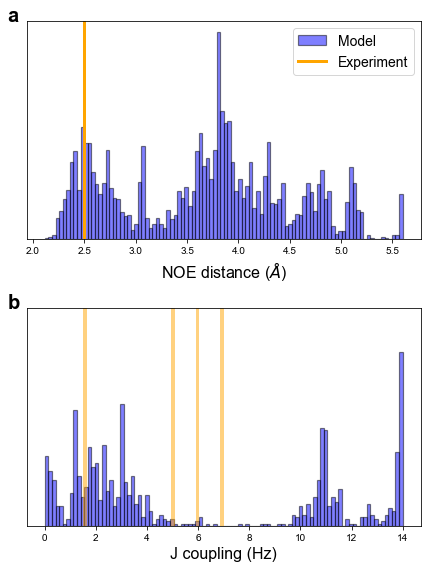

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0,0])
data1 = pd.concat([pd.read_pickle(i) for i in biceps.toolbox.get_files('cineromycin_B/J_NOE/*.noe')])
ax1 = data1["model"].plot.hist(alpha=0.5, bins=100,
    edgecolor='black', linewidth=1.2, color="b", label="Model")
ax1.axvline(list(set(data1["exp"].to_numpy())), c="orange", linewidth=3, label="Experiment")
ax1.legend(fontsize=14)
ax1.set_xlabel(r"NOE distance ($\AA$)", size=16)
ax1.set_ylabel("")
ax1.axes.get_yaxis().set_ticks([])

ax2 = plt.subplot(gs[1,0])
data2 = pd.concat([pd.read_pickle(i) for i in biceps.toolbox.get_files('cineromycin_B/J_NOE/*.J')])
ax2 = data2["model"].plot.hist(alpha=0.5, bins=100,
    edgecolor='black', linewidth=1.2, color="b", label="Model")
data2["exp"].plot.hist(alpha=0.5, bins=40,
    linewidth=1.2, color="orange", label="Experiment", ax=ax2)
ax2.set_ylim(0,100)
ax2.axes.get_yaxis().set_ticks([])
ax2.set_xlabel(r"J coupling (Hz)", size=16)
ax2.set_ylabel("")
axs = [ax1,ax2]
for n, ax in enumerate(axs):
    ax.text(-0.05, 1.0, string.ascii_lowercase[n], transform=ax.transAxes,
            size=20, weight='bold')
fig.tight_layout()
fig.savefig('histogram_of_observables.pdf')

<figure>
<figcaption id="fig:noe-distances">Histogram of (a) experimental (orange) and model data (blue) for 32 NOE distances for 100 structures. (b) For the same structures, 9 scalar coupling observables.
</figcaption>
</figure>


In [66]:
# REQUIRED: number of MCMC steps for each lambda
nsteps = 100000000 # 100 M steps for production
# REQUIRED: specify how many lambdas to sample (more lambdas will provide higher 
# accuracy but slower the whole process, lambda=0.0 and 1.0 are necessary)
n_lambdas = 2
lambda_values = np.linspace(0.0, 1.0, n_lambdas)

#### Constructing conformational ensembles and applying data restraints


<!--
\subsubsection{Constructing conformational ensembles and applying data restraints}
%\subsubsection{Ensemble}

\subsubsection{Constructing thermodynamic ensembles  and applying data restraints}
%\subsubsection{Ensemble}
-->

<!--% NOTE: Why do we need to construct an ensemble? What is the ensemble in most general terms?-->
We begin by constructing an ensemble using prior information from simulation $P(X)$, a collection energies for each state. In this example, energies for each state were taken from QM optimization at the B3LYP/6-3111G(2d,p)/HF/6-31G(d) level of theory.  In most cases we convert the normalized population of each state into free energies through $E = -k_{b}T * \log P$ where $k_{b}$ is the Boltzmann constant and $T$ is the temperature. Alternatively, users can describe the potential energy of conformational states based on their own preference, but it is necessary to pass BICePs reduced free energies (in units of $k_{b}T$).

<!--% NOTE: About the lambda value-->
In general, the goal of this step is to construct an $\verb|ensemble|$ object for each $lambda$-value, where each ensemble contains $\textit{prior}$ information as well as restraint information. Please be aware that the example below is for a single $\lambda$-value for the sake of simplicity, and that posterior sampling for each ensemble will need to be performed iteratively for at least two lambdas $\{0.0, 1.0\}$.  As discussed in \cite{Voelz:2014fga,Ge:2018bdb, voelz2021reconciling}, the lambda value controls how much prior information $P(x)$ is used during posterior sampling. Similar to Free Energy Perturbation (FEP) simulations, the more fine-grained spaced lambda values are employed, the more accurate the results will be. However, finer grained lambda values will increase the computational expense and may not be necessary. Unlike FEP simulations where the $\lambda$-space plays a critical role in accuracy of results, BICePs suffers less in the "overlap issue". Only when the prior distribution (computational modeling) is dramatically different from the posterior likelihood distribution (with experimental restraints), a large number of $\lambda$-values are needed to bridge each ensemble to sample. Normally this may occur with improper modeling (i.e improper force fields) or finite sampling issue. Our previous experience shows lambda values of 0.0, 0.5, 1.0 are robust in accuracy. Nevertheless, it is still important for users to test for optimal settings for their systems and consider the balance between accuracy and efficiency.



In [61]:
####### MCMC Simulations #######
ensemble = biceps.Ensemble(lambda_values[0], energies)

<!--% NOTE: optional argument: parameters-->
Now that we have our $\verb|ensemble|$ object, we want to apply data restraints and possibly adjust some of the restraint settings. However, adjusting the default settings is optional, but definitely important to achieve good sampling. We illustrate in the code block below, that the default restraint settings are readily avalible, which is a list of dictionaries, where each dictionary contains specific keyword arguments (kwargs) for each restraint type in the provided prepared data as shown here:

In [62]:
#pd.DataFrame(biceps.get_restraint_options())
options = biceps.get_restraint_options(input_data)
pd.DataFrame(options)

,ref,sigma,use_global_ref_sigma,extension,weight,log_normal,gamma
0,uniform,"[0.05, 20.0, 1.02]",True,J,1,NaN,NaN
1,uniform,"[0.05, 20.0, 1.02]",True,noe,1,False,"(0.2, 10.0, 1.01)"


Default restraint options can be redefined.  To explain the $\verb|options|$ in greater detail, consider our system Cineromycin B with the two data restraints being J-coupling and NOE distances, respectively. We will redefine the reference potential as well as the discrete sample space for the NOE distance model parameters $\sigma$ and $\gamma$ (unique to NOE), but keep all default parameters for the J coupling restraint. Model parameters $\sigma$ and $\gamma$ reflect both uncertainty in the experimental measurements as well as conformational heterogeneity and intensities to interatomic distances, respectively.

<!--% a note on sigma-space-->
The implementation of reference potentials is a unique feature in BICePs compared to other Bayesian inference based approaches.\cite{Rieping303, perez2015accelerating, beauchamp2014bayesian,  fisher2010modeling, bonomi2016metainference,  bonomi2016metadynamic} It functions to reweigh the informative level of the experimental restraints. Please read these works for more information regarding the theory of reference potentials\cite{Olsson:2013gqa, Olsson:2011kl, Hamelryck:2010deb} and their implementations in BICePs\cite{Voelz:2014fga,Ge:2018bdb, voelz2021reconciling}. A uniform reference potential treats each experimental restraint uniformly i.e., a uniform reference potential is equivalent to not having a reference potential during sampling.  The options for reference potentials are the following: $\verb|"uniform"|$, $\verb|"exponential"|$ and $\verb|"gaussian"|$. The values inside the tuple for sigma (and gamma) define its discrete sample space and follow the formalism of NumPy's method $\verb|arange|$: a minimum of 0.05, maximum of 20.0 and incremented by $\log(1.02)$.


To make this change, we will set the reference potential to an exponential distribution, set the sigma-space to a smaller range of allowed sample space and alter the gamma spacing to have a larger width size.


In [47]:
# Change NOE reference potential from uniform to exponential
options[1]["ref"] = 'exponential'
# Change the sigma-space to a smaller range of allowed sample space
options[1]["sigma"] = (0.05, 5.0, 1.02)
# Alter gamma spacing to have larger width
options[1]["gamma"] = (0.2, 5.0, 1.02)
pd.DataFrame(options)

,ref,sigma,use_global_ref_sigma,extension,weight,log_normal,gamma
0,uniform,"[0.05, 20.0, 1.02]",True,J,1,NaN,NaN
1,exponential,"(0.05, 5.0, 1.02)",True,noe,1,False,"(0.2, 5.0, 1.02)"


Using our established $\verb|ensemble|$ object containing prior informaiton, we now would like to apply data restraints. To do this, we invoke the method $\verb|ensemble.initialize_restraints|$ and provide the prepared data for each state as well as our restraint options. 

In [22]:
ensemble.initialize_restraints(input_data, options)

<!--% NOTE: Summary of Ensemble class. Remind of multiple Lambda values-->
In summary, the $\verb|biceps.Ensemble|$ class was used to construct a single ensemble for a given lambda value. Ensembles must be constructed for all lambda values, where each lambda value scales the reduced free energies of the states. Then, we apply data restraints using our prepared data along with non-default restraint options.  These restraint variables are important in BICePs sampling since nuisance parameters are included in the energy calculation during sampling.  We recommend a broad range of parameters for better accuracy of sampling but the sampling runtime will also increase due to a larger sampling space for a good converged sampling.  Note that increasing this range may increase the sampling requirement for convergence.  After filling the $\verb|ensemble|$ container object with $\verb|Restraint|$ objects (NOE and J) for each conformational state, the $\verb|ensemble|$ object is ready to be passed to $\verb|biceps.PosteriorSampler|$. 


#### Sampling the posterior distribution via Markov Chain Monte Carlo


\subsection{Sampling the posterior distribution via MCMC}
%\subsection{PosteriorSampler}


<!--% NOTE: What does this class do? Why does it need the ensemble/how is it used?
% what does posterior sampler do?
-->

The primary objective of this step is to perform MCMC sampling of the posterior distribution, which consists of nuisance parameter space as well as conformational space . During MCMC, what is actually evaluted is an effective energy function (in $k_{b}T$). Suitably, all of the required information to perform energy evaluations is inherited from the $\verb|ensemble|$ object.  The energy function  can be obtained as the negative logarithm of the posterior probability given in Eq.\ref{eq:nuisance}:

\begin{equation}
\begin{split}
-\ln P(X_{i},  \sigma^{\text{NOE}}, \sigma^{\text{J}}, \gamma^{\prime} | D) = &\left(N_{j}^{\text{J}}+1\right) \ln \sigma^{\text{J}}+\frac{\chi^{2}(X_{i})}{2 (\sigma^{\text{J}})^{2}}+\frac{N_{j}^{\text{J}}}{2} \ln 2 \pi \\
&+ \left(N_{j}^{\text{NOE}}+1\right) \ln \sigma^{\text{NOE}}+\frac{\chi^{2}(X_{i})}{2 (\sigma^{\text{NOE}})^{2}}+\frac{N_{j}^{\text{NOE}}}{2} \ln 2 \pi\\
&+ \sum_{j} \left( \ln \beta_{j} - r_{j}^{\text{NOE}}/\beta_{j}\right) + E(X_{i})/k_{b}T + \sum_{i} \exp\left(-E(X_{i})/k_{b}T\right)
\label{eq:neglogP}
\end{split}
\end{equation}


The quantity $\chi^{2}(X)$ is the sum of squared errors, computed as
\begin{equation}
\chi^{2}(X)=\sum_{j} w_{j}\left(r_{j}(X)-r_{j}^{\exp }\right)^{2}
\label{eq:chi2}
\end{equation}

where $w_{j}$ is a weight parameter (for example, $w_{j}=1/3$ is the uniform weight for each hydrogen in a methyl group), where the effective number of coupling constants is $N_{j} = \sum_{j} w_{j}$.


The Metropolis-Hastings criterion is used to determine if a new jump is accepted or rejected in the MCMC simulation.  The Metropolis-Hastings algorithm was used for MCMC sampling of the full posterior distribution over variables, $\theta = (X_{i}, \sigma^{\text{NOE}}, \sigma^{\text{J}}, \gamma^{\prime})$ where $i$ is an index running over all conformations. Iteratively, candidate moves $\theta \rightarrow \theta^{\prime}$ are proposed, and either accepted or rejected by the Metropolis criterion, which accepts the move with probability min$\left[1, P(\theta^{\prime})/P(\theta) \right]$.  Overall, the result yields an estimate of the full posterior distribution $P(X, \sigma | D)$.  The most probable values of $\sigma$ can be obtained by the marginal distribution $P(\sigma | D) = \int P(X, \sigma | D) dX$, and the state populations are estimated as $P(X | D) = \int P(X, \sigma | D) d\sigma$.

A key advantage of MCMC sampling is that the error estimate is independent of the dimension $d$ of the parameter space to be sampled. On the other hand, this acts as a disadvantage such that convergence is slowly achieved. Therefore, MCMC sampling is not optimal for low dimensional (e.g 1D) integrals but rather a better option for high dimension task. Since BICePs is designed for working with multiple experimental observables and for some observables (i.e NOE and protection factors) more than one nuisance parameters are included in sampling, MCMC sampling is an attractive choice for such a problem.


To initialize the class, the only requirement is the \verb|ensemble| object.


In [23]:
sampler = biceps.PosteriorSampler(ensemble)
sampler.sample(nsteps=10000, burn=0, print_freq=1000, verbose=True, progress=0)

Step		State	Para Indices		Avg Energy	Acceptance (%)
0		[14]	[151, 151, 81]		101.930		100.00	True
1000		[32]	[198, 141, 94]		10.564		58.24	True
2000		[56]	[220, 133, 97]		8.339		61.87	False
3000		[2]	[235, 139, 95]		8.183		63.61	True
4000		[87]	[225, 122, 100]		6.018		65.66	True
5000		[23]	[247, 142, 100]		7.852		65.99	True
6000		[45]	[242, 133, 93]		7.422		67.47	False
7000		[60]	[243, 119, 103]		13.025		67.43	True
8000		[27]	[243, 131, 96]		7.055		67.55	False
9000		[45]	[241, 142, 101]		8.779		68.00	True

Accepted 67.97 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.31 29.09 29.09  6.57] % 



<!--
% NOTE: What specifics do we need to know about the Code Block above?
%Code Block \ref{cb:Posterior}
-->

Next, the posterior distribution is sampled by invoking the $\verb|sampler.sample|$ method from the $\verb|sampler|$ object and specifying the number of steps to be sampled (\mintinline{python}{nsteps}).  This number is important for convergence and normally is not known a \textit{priori}. We developed multiple statistical methods to check convergence of the outcome trajectories and more details will be discussed later. To save all the necessary information regarding MCMC sampling, we invoke $\verb|sampler.process|$ to dump a NumPy z-compressed file ($\verb|filename=f'traj_lambda{lam}.npz'|$) and corresponding light-weight $\verb|sampler|$ object, where $\verb|lam|$ is the lambda value of the ensemble.

<!--
% NOTE: Summary of PosteriorSampler
-->
In Code Block \ref{cb:Posterior} we have exhaustively sampled the posterior distribution and made full use of the information stored in the $\verb|ensemble|$ object with the $\verb|biceps.PosteriorSampler|$ class. 


In [10]:
# Multiprocess trajectories for each $\lambda$-value with a built-in decorator
@biceps.multiprocess(iterable=lambda_values)
def mp_lambdas(lam):
    ensemble = biceps.Ensemble(lam, energies)
    ensemble.initialize_restraints(input_data, options)
    sampler = biceps.PosteriorSampler(ensemble)
    sampler.sample(nsteps=nsteps, print_freq=1000, verbose=False)
    sampler.traj.process_results(outdir+'/traj_lambda%2.2f.npz'%(lam))
    filename = outdir+'/sampler_lambda%2.2f.pkl'%(lam)
    biceps.toolbox.save_object(sampler, filename)

Number of CPUs: 10
Number of processes: 2


100%|████████████████████████████████████████████████████▉| 99845985/100000000 [23:57<00:02, 70242.93it/s]


Accepted 71.218199 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.741267 29.894237 29.894237  8.582695] % 



100%|████████████████████████████████████████████████████▉| 99998464/100000000 [23:59<00:00, 68926.67it/s]


Accepted 64.303679 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.742365 29.961238 29.961238  1.600076] % 



100%|████████████████████████████████████████████████████| 100000000/100000000 [23:59<00:00, 69459.05it/s]


#### Assessing the convergence of MCMC trajectories

<!--\subsection{Assessing the convergence of MCMC trajectories}
%\subsection{Convergence}
% NOTE: Why should we care? What should in mind before checking convergence with this class
-->

Typically, massive amounts of care is involved with setting up simulations. We stress the importance in making sure that when reweighting simulated ensembles that we do it accurately. Thus, it is essential that we attempt to objectively uncover the validity of our MCMC trajectories to ensure proper sampling & convergence. Despite there being no single clear best practice to quantify MCMC sampling quality\cite{grossfield2018best}, we added an assortment of different approaches to test convergence inside of our $\verb|biceps.Convergence|$ class. Here, we will find methods that suit our needs e.g., autocorrelation, block-averaging, bootstrapping, Jensen-Shannon divergence (JSD) and more. Previously, we assessed trajectory convergence by comparing populations and BICePs scores from sets of trajectories of varying number of steps. For converged results, the populations and BICePs score should be similar regardless of the trajectory length.

We stress that users should check that their MCMC simulations satisfy the following items before checking convergence: 1) All states are sampled at least once over all $\lambda$ values.  The MBAR algorithm estimates conformational state populations and the states not sampled for any lambda value will be considered to have infinitely high potential energy and the corresponding predicted population will be infinite small. 2) The MCMC acceptance percentage is high. Low acceptance percentage is a sign of inefficient sampling and implies that many more MCMC steps are required to adequately sample a certain parameter space. Alternatively, one can modify the parameter space by decreasing the width and have a more fine grained sample space. Another option is to start at larger sigma values when sampling.

<!--% NOTE: What does the convergence class have to offer (in general)? What is needed?-->

To evaluate the convergence criteria in a more statistically rigorous manor, we added numerous tools inside the Convergence class which should provide a great deal of aid to the user. To get started, the class only requires the $\verb|filename|$ of a biceps MCMC trajectory (including its relative path) for initialization. In this step, the trajectory is read into memory and stored as the local variable convergence object $\verb|C|$. To view the trajectory, as shown in Figure \ref{fig:autocorr}a, we plot the time-series of sampled nuisance parameters using $\verb|C.plot_traces(str(figname))|$. The time-series of sampled $\sigma_{NOE}$ implies adequate sampling with many transitions about the mean of 0.695Å.  Here, we see local convergence, but let us be more statistically rigorous. 

<!--
% NOTE: What specifics do we need to know about the Code Block above?
-->
To do this, we first determine the trajectory length at which sampling becomes decorrelated. Autocorrelation curves are computed for each time-series of sampled nuisance parameters.

\begin{equation}
C\left(\theta_{t}, \theta_{t+\tau}\right) \equiv \frac{\overline{\left(\theta_{t}-\overline{\theta}\right)\left(\theta_{t+\tau}-\overline{\theta}\right)}}{{s_{\theta}}^{2}} \Rightarrow c_{\tau}
\label{eq:g}
\end{equation}


where $s(\theta)^{2}$ is the variance and $c_{\tau}$ is independent of the lagtime $\tau$. To find the autocorrelation time ($\tau_{auto}$), we take integral of $C_{\tau}$ over all lagtimes, which tells us the length at which sampling becomes decorrelated.  The computed autocorrelation times for each nuisance parameter are stored in $\verb|C|$ to be used for further convergence analysis. By default, our $\verb|get_autocorrelation_curves|$ method uses an autocorrelation function ($\verb|method="auto"|$) with a window of length $\verb|maxtau=10000|$ to compute the autocorrelation time. To obtain the autocorrelation time, we take the integral of the autocorrelation function over all lag-times $\tau$ shown in Figure \ref{fig:autocorr}b (with $\verb|maxtau=5000|$). Three options for the argument $\verb|method|$ are provided: block average ($\verb|"block-avg-auto"|$), exponential fitting ($\verb|"exp"|$) or autocorrelation function ($\verb|"auto"|$).  Each method varying in the level of statistical sophistication to compute the autocorrelation times of each nuisance parameter. 




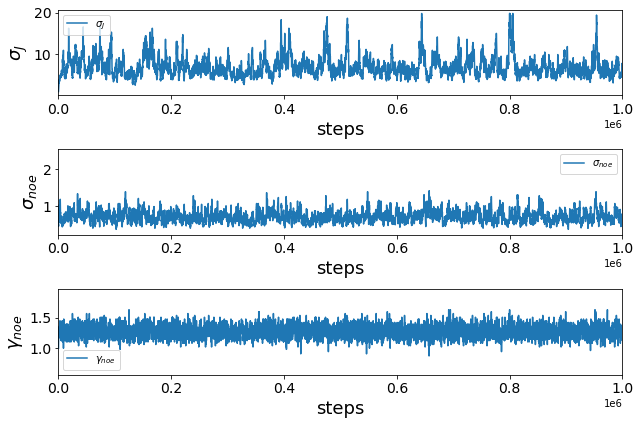

In [5]:
C = biceps.Convergence(filename=outdir+"/traj_lambda1.00.npz")
C.plot_traces(figname="traces.pdf", xlim=(0, nsteps))

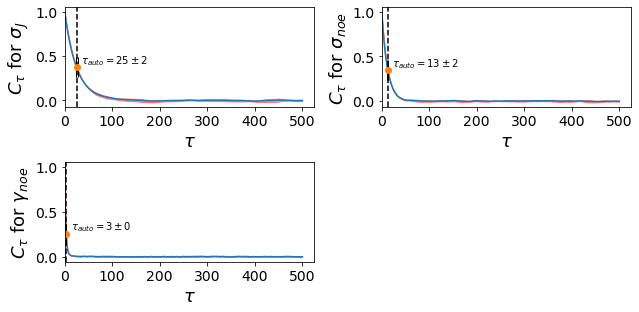

In [9]:
C.get_autocorrelation_curves(method="block-avg", maxtau=500, nblocks=5)

After the autocorrelation times have been stored, $\verb|C.process|$ is called to perform a series of operations including the output of plots (Figure \ref{fig:JSD_conv_unconv}a.) from the resulting JSD analysis.  By default, there are numerous preset arguments for JSD analysis: $\verb|nround=100|$ is the number of rounds of bootstrapping when computing JSDs, $\verb|nfold=10|$ is the number of partitions in the shuffled (subsampled) trajectory.

Jensen-Shannon divergence (JSD) is an improved method from Kullback-Leibler divergence and is a statistical way to measure the similarity between two probability distributions. In our convergence test, we are aiming to check if we use more data, will the distribution be different or similar to the less data which is a perfect situation that JSD calculation could be helpful. Given two sets data from BICePs sampling $P_1$ and $P_2$, to check if these two distribution is similar or not, we can compute the JSD as:

\begin{equation}
JSD = H(P_{1}\cup P_{2}) - {\pi_1}{H(P_1)} - {\pi_2}{H(P_2)}
\label{eq:JSD_def}
\end{equation}
where $H$ is the Shannon entropy of distribution $P_i$ and $\pi_i$ is the weight for the probability distribution $P_i$.
Specifically, in BICePs the $P_i$ is the distribution of sampled parameters and ${H(P_i)}$ can be computed as:

\begin{equation}
{H(P_i)} = \sum -\frac{r_i}{N_i}*\ln{\frac{r_i}{N_i}}
\end{equation}
where $r_i$ and $N_i$ represents sampled times of a specific parameter index and the total number of samples of the parameter, respectively. $\pi_i$ can be computed as $\frac{N_i}{N_{total}}$ where $N_{total} = \sum{N_i}$. Combined together we have:

\begin{equation}
JSD = \sum{(-\frac{r_{total}}{N_{total}}*\ln{\frac{r_{total}}{N_{total}}})} - \frac{N_i}{N_{total}}*\sum(-\frac{r_i}{N_i}*\ln{\frac{r_i}{N_i}})
\label{eq:JSD}
\end{equation}

where $i = 1, 2$ in this example.
In BICePs, we can import different amount of data into our JSD calculation. To do that, we may use $p\%$ ($p = 10,20,...100$) data and divide the dataset ($P_{total}$) into two parts (the first half and second half) to get $P_1$ and $P_2$ in eq \ref{eq:JSD_def} and compute the JSD value ($JSD_{single}$) using eq \ref{eq:JSD}. Then we can randomly pick up $N_{total}/2$ points from $P_{total}$ as $P_1$ ($N_{total}$ is the total number of data after chopped) and the remaining data as $P_2$. In this way, we are mixing the data and the computed JSD ($JSD_{random}$) from this mixing data should be smaller than the computed JSD from just first versus second half data. But if the dataset is completely converged, $JSD_{single}$ and $JSD_{random}$ should be close. Repeat mixing data $N$ times, we shall get $\Big\{JSD_{random}\Big\}_N$ values and a corresponded distribution. Our null hypothesis is the computed $JSD_{single}$ is not in the distribution of $\Big\{JSD_{random}\Big\}_N$. To test if we can accept or reject the hypothesis, we rank the $JSD_{single}$ values in $\Big\{JSD_{random}\Big\}_N$ in ascending order. If it is in the top 99\% ranked (see Figure \ref{fig:JSD_exp}b), then we reject the hypothesis which indicates $P_1$ and $P_2$ no matter mixing the data or not are drawn from a mutual distribution and the data is converged. If the ranked $JSD_{single}$ is in the last 1\% (Figure \ref{fig:JSD_exp}a), the data is not converged yet.


As an exmaple, Figure \ref{fig:JSD_conv_unconv} shows JSD analysis on trajectories with different amount of steps (10K, 100K, 1M, 10M, 100M) with two $\lambda$ values ($\lambda = 0.0, 1.0$). Panel (a) shows JSD values (red dots) for a given percentage of the dataset, where the shaded region defines the 95\% confidence interval of the distribution. Interestingly, panel (b) suggests that the 10k step trajectory has locally converged and panel (c) shows JSD values outside of the 95\% confidence interval representing false positives suggesting that more sampling is needed. Hence, the need to analyze convergence of trajectories for various number of steps. The last two panels (d and e) clearly show convergence and suggest that 1M steps is sufficient.

<!--
\begin{figure}[h!]
\centering
\includegraphics[scale=0.3]{images/convergence_with_JSD/JSD_dist_Conv_notConv.pdf}
  \caption{JSD distributions of MCMC trajectories with different number of steps. (a and c) The trajectory (100K steps) is not converged as more than 80\% data is used, the $JSD_{single}$ is out of the distribution of $JSD_{random}$. (b) The trajectory sampled for 10k steps using the same conditions is locally converged. (d and e) Trajectories of 1M and 10M steps are converged.}
\label{fig:JSD_conv_unconv}
\end{figure}
-->

<figure>
<img src="figures/convergence_with_JSD/JSD_dist_Conv_notConv.pdf" width="100%">
<figcaption id="fig:">JSD distributions of MCMC trajectories with different number of steps. (a and c) The trajectory (100K steps) is not converged as more than 80\% data is used, the $JSD_{single}$ is out of the distribution of $JSD_{random}$. (b) The trajectory sampled for 10k steps using the same conditions is locally converged. (d and e) Trajectories of 1M and 10M steps are converged. 
</figcaption>
</figure>



<!--
% NOTE: Summary of Convergence
-->
The convergence submodule is extremely convenient and useful for users to objectively quantify sampling quality. Still, convergence checking could get complicated. For example, a larger value of $\verb|maxtau|$ may be necessary in cases of more slowly decorrelated time series. Occasionally, negative values of $\tau_{auto}$ may be obtained indicating the amount of data is not enough for computing autocorrelation time. Despite there not being a one-size-fits-all approach to checking the validity of MCMC trajectories,  our team decided to include a depot of methods to check convergence. By checking convergence, we can put more trust in our next step, analysis.






#### Analysis
<!--
%\subsection{Analysis}
% NOTE: What does the Analysis class do?
-->

Our biceps workflow ends by predicting conformational state populations, computing the biceps score and plotting distributions. This has been made easy via the $\verb|biceps.Analysis|$ class which automatically analyzes our MCMC trajectories. As we mentioned here \cite{Voelz:2014fga,Ge:2018bdb, voelz2021reconciling}, BICePs uses a free energy perturbation approach in $\lambda$ space, where sampling is done independently for multiple $\lambda$ values. Then using MBAR we can infer the potential energy of snapshots in ensemble $j$ which is originally sampled in ensemble $i$. From this, populations can be predicted for each conformational state and the biceps score can be computed. More details can be found in this work \cite{Shirts:2008eza}.


From Bayesian model selection, BICePs is able to calculate a Bayes factor-like quantity that we call the BICePs score, which quantifies the support of evidence for one model over another. The quality of a model $k$ that uses a prior $P^{(k)}(X)$ from theoretical modeling can be assessed by the posterior likelihood $Z^{(k)}$ of model $k$:

\begin{equation}
Z^{(k)} = \int P^{(k)}(X,\sigma | D)  dX d\sigma =\int P^{(k)}(X) Q(X) dX.
\end{equation}

One way to think of $Z^{(k)}$ is as an integral over the entire input space (including nuisance parameters) of the model.  Another way, however, is to think of $Z^{(k)}$ as an \textit{overlap} integral between the prior $P^{(k)}(X)$ and a likelihood function $Q(X) = \int [Q(\mathbf{r}(X)|D,\sigma)/Q_{\text{ref}}(\mathbf{r}(X)) ] P(\sigma) d\sigma$. This integral reaches the maximum when $P^{(k)}(X)$ most closely matches the likelihood distribution $Q(X)$ specified by the experimental restraints.

Suppose we have two models (1) and (2) with priors $P^{(1)}$ and $P^{(2)}$, and we want to know which one is more consistent with experimental measurements.  In Bayesian statistics, the comparison is often made using the ratio of posterior model probabilities, $Z^{(1)}/Z^{(2)}$, also called the Bayes factor.

In BICePs, we consider a free energy-like quantity, called the BICePs score:
\begin{equation}
f^{(k)} = -\ln \frac{Z^{(k)}}{Z_0},
\label{eq:reference_state}
\end{equation}


Not only can this be used to show that reweighted populations are more consistent with experimental data, it can also be used to rank different simulated ensembles by their accuracy in reproducing experimental observables (Ge and Voelz, 2018).  Instantiating this class requires a path to glob the $\verb|'*.npz'|$ trajectories as well as the number of states ($\verb|nstates|$).


Loading results/traj_lambda0.00.npz ...
Loading results/traj_lambda1.00.npz ...
not all state sampled, these states [ 5 11 16 24 25 26 27 34 40 42 48 76 77 81 87 95 98] are not sampled
Loading results/sampler_lambda0.00.pkl ...
Loading results/sampler_lambda1.00.pkl ...
lam = [0.0, 1.0]
nstates 100
Writing results/BS.dat...
...Done.
Writing results/populations.dat...
...Done.
BICePs Scores = [0.         0.24138802]


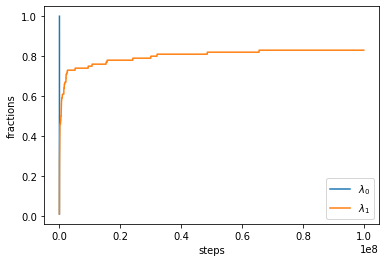

In [16]:
############ MBAR and Figures ###########
%matplotlib inline
# Let's do analysis using MBAR algorithm and plot figures
A = biceps.Analysis(outdir, nstates=len(energies))
biceps.toolbox.save_object(A, "analysis_object.pkl")
#pops = A.P_dP[:,n_lambdas-1]
pops, BS = A.P_dP, A.f_df
print(f"BICePs Scores = {BS[:,0]}")


The following analysis files will be exported to the directory where the trajectory live: (1) the predicted populations of each conformational state using PyMbar\cite{Shirts:2008eza} ($\verb|populations.dat|$)
(2) the BICePs score ($\verb|BS.dat|$).  Invoking the $\verb|plot|$ method in $\verb|Analysis|$ produces Figure \ref{fig:BICePs_outcome} ($\verb|BICePs.pdf|$).  This figure shows the posterior distribution of inferred state populations and sampled nuisance parameters ($\sigma_J$, $\sigma_{noe}$ and $\gamma$).  Our results shown in Figure \ref{fig:BICePs_outcome} perfectly reproduce previous published work \cite{Voelz:2014fga} which indicates reliability of the latest version.


In [51]:
import pickle

with open("analysis_object.pkl", 'rb') as f:
    A = pickle.load(f)
    

In [68]:
pops, BS = A.P_dP, A.f_df

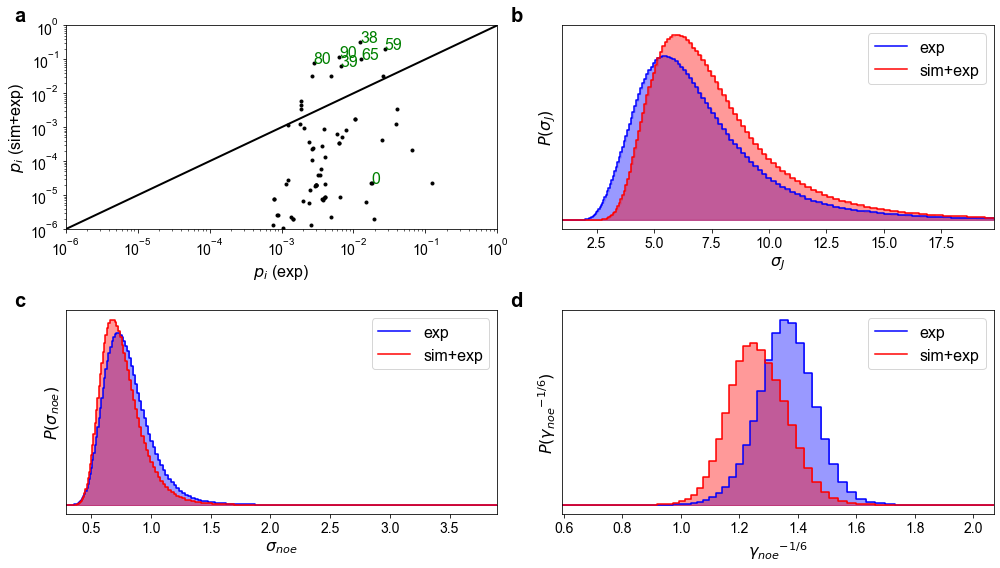

In [64]:
#A.plot(plottype="hist", figname="BICePs.pdf", figsize=(14,8),
A.plot(plottype="step", figname="BICePs_.pdf", figsize=(14,8),
       label_fontsize=16, legend_fontsize=16)

<figure>
    <figcaption style="text-align: justify" id="fig:posterior">
    (a) A comparison of conformational state populations $p_{i}(\text{exp})$ inferred using only experimental restraints, vs. BICePs populations $p_{i}(\text{sim + exp})$ inferred using a combination of the simulation-based prior and experimental restraints. States on the lower right are highly compatible with experimental restraints, but are conformationally strained according the simulation model. Conformational states near the top of the graph are both reasonably compatible with experimental restraints, and highly-populated according to the simulation model. (c) The marginal posterior distribution of $\sigma_{\text{NOE}}$, the uncertainty parameter for NOE distance restraints. (b) The marginal posterior distribution of $\sigma_{\text{J}}$ , the uncertainty parameter for J-coupling constants. (d) The marginal posterior distribution of $\gamma_{\text{NOE}}$, the scaling parameter for the NOE distances, remains near 1.25 throughout the MCMC sampling.
    </figcaption>
</figure>


In panel (a) in Figure {} we can see the population of each states in the presence (y-axis) and absense (x-axis) of computational modeling prior information. You can find some states (e.g state 38, 59, 65, 90) get awarded upon including information from simulation. After mapping back to the energies of these states, we find that these correspond to some of the low energy structures.  Conversely, some of the high energy states have been pentalized e.g., state 0.  For futher information regarding how well our reweighted populations relate to the crystal isoforms of albocycline, the O-methylated analog of cineromycin B, please see this work\cite{Voelz:2014fga}.  Panels (b)-(d) show the distribution of nuisance parameters in the presence or absence of computational modeling information. 


The populations ($\verb|pops|$) are stored is a NumPy array containing a row for each state ($\verb|nstates|$=100) and four columns corresponding to our 2 lambda values (first 2 columns) and their corresponding population change (last 2 columns). Using the reweighted populations of Cineromycin B, the experimental observables $r_{j}^{\text{exp}}$ can be compared to our ensemble-averaged back calculated observable $<r_{j}> = \sum_{X} r_{j}(X)P(X)$ after BICePs reweighting. 



<img src="results/reweighted_observables.png">


Maximum-likelihood values of nuisance parameters $\sigma_{\text{J}}^{*}$, $\sigma_{\text{NOE}}^{*}$, $\gamma_{\text{NOE}}^{*}$ from posterior sampling can be considered the best estimate of the uncertainty in the experimental observables. The treatment of experimental NOE distances (2.5Å for all) comes from the lack of experiemntal data. We can see from the posterior distribution of $\gamma$ with greatest frequency about 1.25Å indicates that the estimated true NOE distance is our initial guess of 2.5Å scaled by 1.25 resulting in an experimental ensemble averaged NOE distance $3.12 \pm 0.7Å$, as shown as the dotted black line in Figure {}.



<!--% NOTE: Again, remember that Ensemble and PosteriorSampler CAN be performed in parallel.-->
\section{Conclusion}

We have introduced the BICePs v2.0 software package which is a Bayesian inference approach that can be used for protein structure determination, reweighting simulated ensembles, performing objective model selection, and more that exceeds the scope of this application using cineromycin B. Our algorthim is special in that it is used as a post-simulation processing step, properly accounts for differences in experimental restraints by correctly implementing reference potentials, and provides an objective metric for model selection through the BICePs score.  This tool supports a range of experimental observables (NOE, Jcouplings, chemical shifts and protection factors) and will continue to grow. BICePs v2.0 is currently written in Python, but we have plans to imrpove the speed of the sampling routines with C++ and include more enhanced sampling techniques inside the algorithm. Users can install the package through pip/GitHub (\url{https://biceps.readthedocs.io/en/latest/installation.html}). More detailed documentation and tutorials can be found at: \url{https://biceps.readthedocs.io}. For any issues or questions, please submit the request on GitHub: \url{https://github.com/vvoelz/biceps}.






   

### Data and Software Availability

\section*{Data and Software Availability}


The BICePs 2.0 algorithm is freely available at \url{https://github.com/vvoelz/biceps}.
All input files, setup and subset of simulated trajectory data (used for analysis) are available at: \url{https://github.com/vvoelz/biceps/tree/master/docs/examples/full_examples/cineromycinB}.




A more detailed example of using \mintinline{python}{biceps.Preparation} class can be found at: \url{https://biceps.readthedocs.io/en/latest/examples/Tutorials/Prep_Rest_Post_Ana/preparation.html}




More detailed explanation and examples can be found at online documentations (\url{https://biceps.readthedocs.io}).



More details for each Code Block can be found in the tutorials/examples tab on our website (\url{https://biceps.readthedocs.io}) as well as the API reference. 

### ACKNOWLEDGMENTS

\section{ACKNOWLEDGMENTS}

This research was supported in part by the National Institutes of Health through grant 1S10OD020095-01. Y.G and R.R was supported by National Institutes of Health grant 1R01GM123296. This research includes calculations carried out on Temple University’s HPC resources and thus was supported in part by the National Science Foundation through major research instrumentation grant number 1625061 and by the US Army Research Laboratory under contract number W911NF-16-2-0189.


\bibliographystyle{plain}
\bibliography{references}

# SI

Table. Maximum-likelihood values of nuisance parameters $\sigma_{\text{J}}^{*}$, $\sigma_{\text{NOE}}^{*}$, $\gamma_{\text{NOE}}^{*}$ from posterior sampling.

In [21]:
mlp = pd.concat([A.get_max_likelihood_parameters(model=i) for i in range(len(lambda_values))])
mlp.reset_index(inplace=True, drop=True)
mlp

,sigma_J,sigma_noe,gamma_noe
0,5.569432,0.724425,1.365358
1,6.028532,0.696294,1.261380


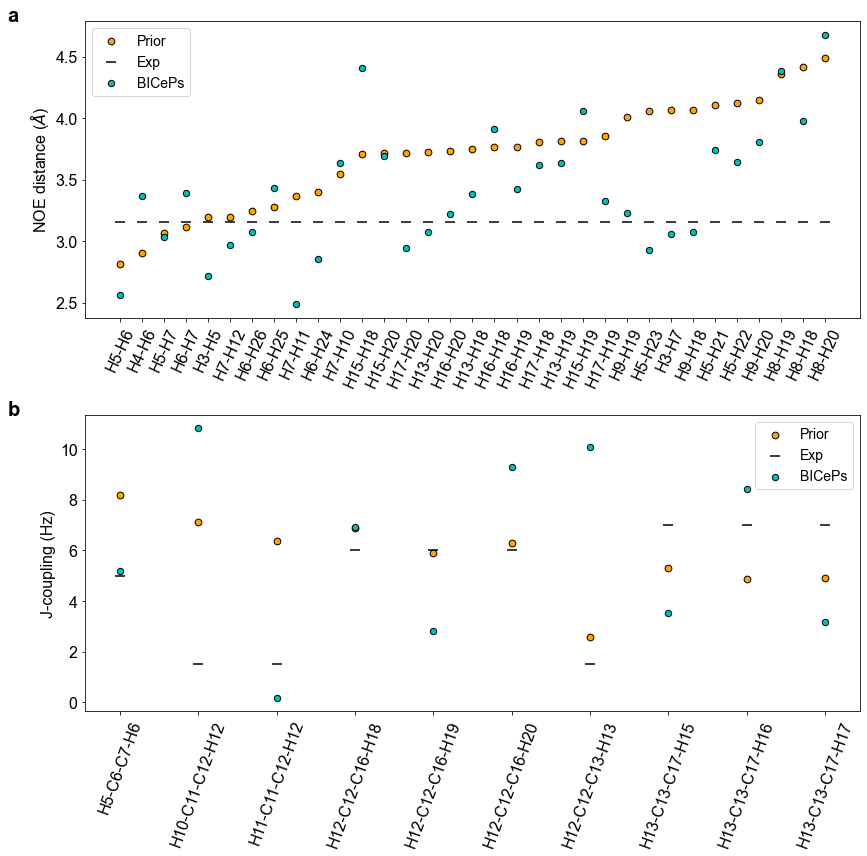

In [69]:
# NOTE: Get Prior MSM populations
prior_pops = np.loadtxt(data_dir+"prior_pops.txt")
prior_pops /= prior_pops.sum()

noe = [pd.read_pickle(i) for i in biceps.toolbox.get_files(data_dir+"J_NOE/*.noe")]
#  Get the ensemble average observable
noe_Exp = noe[0]["exp"].to_numpy()
noe_model = [i["model"].to_numpy() for i in noe]

noe_prior = np.array([w*noe_model[i] for i,w in enumerate(prior_pops)]).sum(axis=0)
noe_reweighted = np.array([w*noe_model[i] for i,w in enumerate(pops[:,n_lambdas-1])]).sum(axis=0)

distance_labels = [f"{row[1]['atom_name1']}-{row[1]['atom_name2']}" for row in noe[0].iterrows()]
distance_label_indices = np.array([[row[1]['atom_index1'], row[1]['atom_index2']] for row in noe[0].iterrows()])


J = [pd.read_pickle(file) for file in biceps.toolbox.get_files(data_dir+'J_NOE/*.J')]
#  Get the ensemble average observable
J_Exp = J[0]["exp"].to_numpy()
J_model = [i["model"].to_numpy() for i in J]

J_prior = np.array([w*J_model[i] for i,w in enumerate(prior_pops)]).sum(axis=0)
J_reweighted = np.array([w*J_model[i] for i,w in enumerate(pops[:,n_lambdas-1])]).sum(axis=0)

J_labels = [f"{row[1]['atom_name1']}-{row[1]['atom_name2']}-{row[1]['atom_name3']}-{row[1]['atom_name4']}" for row in J[0].iterrows()]
J_label_indices = np.array([[row[1]['atom_index1'], row[1]['atom_index2'], row[1]['atom_index3'], row[1]['atom_index4']] for row in J[0].iterrows()])




fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 1)


ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
data = []
for i in range(len(noe_reweighted)):
    data.append({"index":i,
        "reweighted noe":noe_reweighted[i], "prior noe":noe_prior[i],
        "exp noe":noe_Exp[i]*mlp['gamma_noe'].to_numpy()[-1], "label":distance_labels[i]
        })
data1 = pd.DataFrame(data)

_data1 = data1.sort_values(["prior noe"])
_data1 = _data1.reset_index()
#print(_data1)


#ax1 = data1.plot.scatter(x='index', y="reweighted noe", s=5, edgecolor='black', color="b", label="BICePs")
ax1.scatter(x=_data1["label"].to_numpy(), y=_data1["prior noe"].to_numpy(),
            s=45, color="orange", label="Prior", edgecolor='black',)
ax1.scatter(x=_data1["label"].to_numpy(), y=_data1["exp noe"].to_numpy(),
            s=100, marker="_", color="k", label="Exp")
ax1.scatter(x=_data1["label"].to_numpy(), y=_data1["reweighted noe"].to_numpy(),
            s=40, color="c", label="BICePs", edgecolor='black')
ax1.legend(fontsize=14)
#ax1.set_xlabel(r"Index", size=16)
ax1.set_ylabel(r"NOE distance ($\AA$)", size=16)


data = []
for i in range(len(J_reweighted)):
    data.append({"index":i,
        "reweighted J":J_reweighted[i], "prior J":J_prior[i], 
        "exp J":J_Exp[i], "label":J_labels[i]
        })
data1 = pd.DataFrame(data)

ax2.scatter(x=data1['label'].to_numpy(), y=data1["prior J"].to_numpy(),
            s=45, color="orange", label="Prior", edgecolor='black',)
ax2.scatter(x=data1['label'].to_numpy(), y=data1["exp J"].to_numpy(),
            s=100, marker="_", color="k", label="Exp")
ax2.scatter(x=data1['label'].to_numpy(), y=data1["reweighted J"].to_numpy(),
            s=40, color="c", label="BICePs", edgecolor='black')
ax2.legend(fontsize=14)
#ax2.set_xlabel(r"Index", size=16)
ax2.set_ylabel(r"J-coupling (Hz)", size=16)

ticks = [
         ax1.xaxis.get_minor_ticks(),
         ax1.xaxis.get_major_ticks(),]
xmarks = [ax1.get_xticklabels(),
        ]
ymarks = [ax1.get_yticklabels(),
        ]
for k in range(0,len(ticks)):
    for tick in ticks[k]:
        tick.label.set_fontsize(16)
for k in range(0,len(xmarks)):
    for mark in xmarks[k]:
        mark.set_size(fontsize=16)
        mark.set_rotation(s=65)
for k in range(0,len(ymarks)):
    for mark in ymarks[k]:
        mark.set_size(fontsize=16)
        mark.set_rotation(s=0)


ticks = [
         ax2.xaxis.get_minor_ticks(),
         ax2.xaxis.get_major_ticks(),]
xmarks = [
         ax2.get_xticklabels(),
        
        ]
ymarks = [
         ax2.get_yticklabels(),
        ]
for k in range(0,len(ticks)):
    for tick in ticks[k]:
        tick.label.set_fontsize(16)
for k in range(0,len(xmarks)):
    for mark in xmarks[k]:
        mark.set_size(fontsize=16)
        mark.set_rotation(s=70)
for k in range(0,len(ymarks)):
    for mark in ymarks[k]:
        mark.set_size(fontsize=16)
        mark.set_rotation(s=0)


axs = [ax1,ax2]
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.0, string.ascii_lowercase[n], transform=ax.transAxes,
            size=20, weight='bold')
fig.tight_layout()
fig.savefig(f"{outdir}/reweighted_observables.pdf", dpi=500)

<figure>
    <figcaption style="text-align: justify" id="fig:posterior">
      BICePs reweighted observables compared against experiment and prior for (a) NOE and (b) J-coupling.
    </figcaption>
</figure>





<span style="color:red;font-size:18pt">
</span>


#### To quickly test MCMC convergence (w/ out knowing if you have sampled all of the states in other $\lambda$-trajectories) 

100%|███████████████████████████████████████████████████████| 1000000/1000000 [00:15<00:00, 65796.25it/s]



Accepted 64.2746 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.7268 29.956  29.956   1.5918] % 

not all state sampled, these states [ 3  4  5  9 11 13 14 15 18 19 22 23 24 25 26 27 29 34 40 41 42 48 51 52
 54 57 61 64 73 74 76 77 78 81 83 87 95 96 98 99] are not sampled
NOTE: Found a negative autocorrelation time...


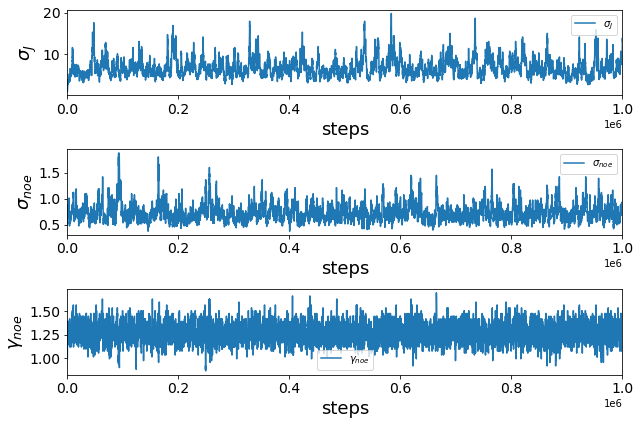

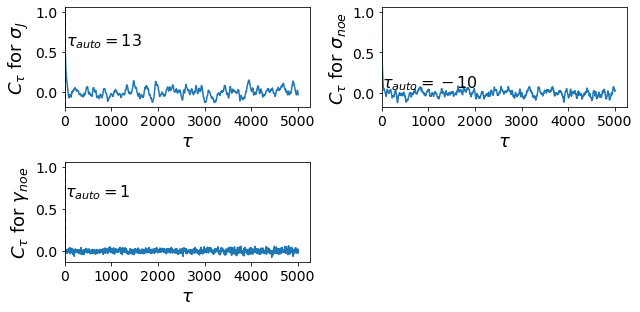

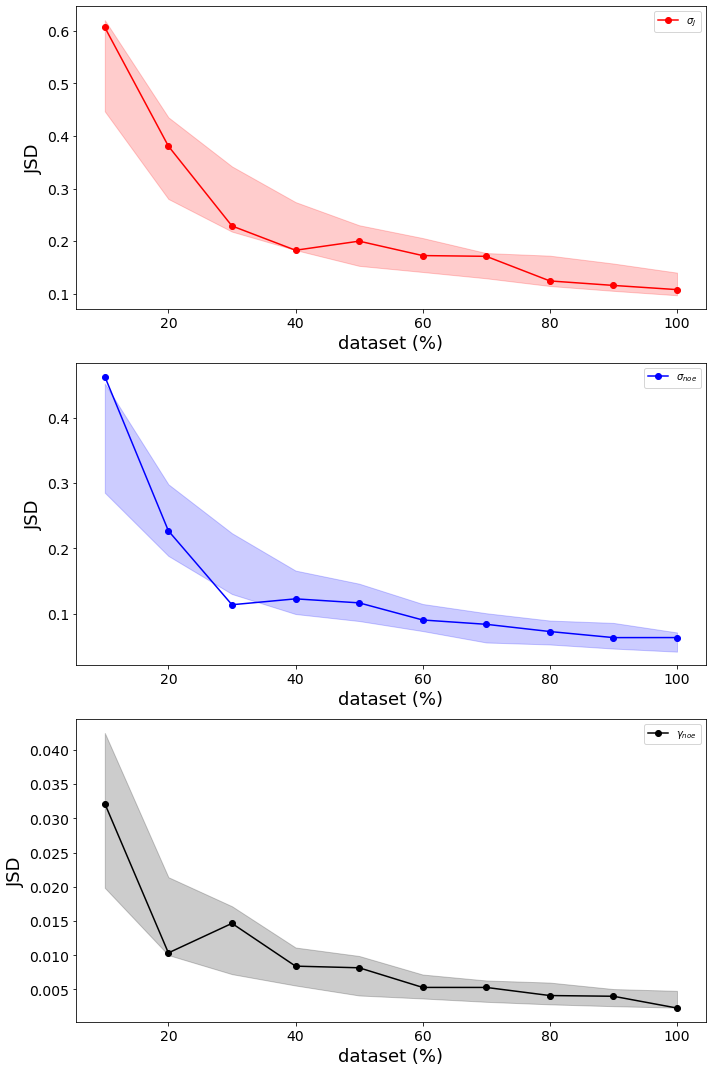

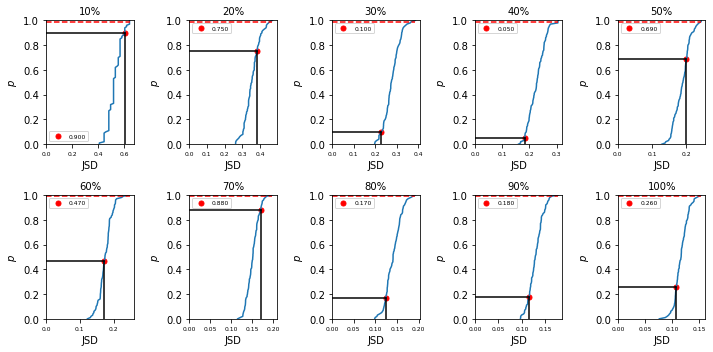

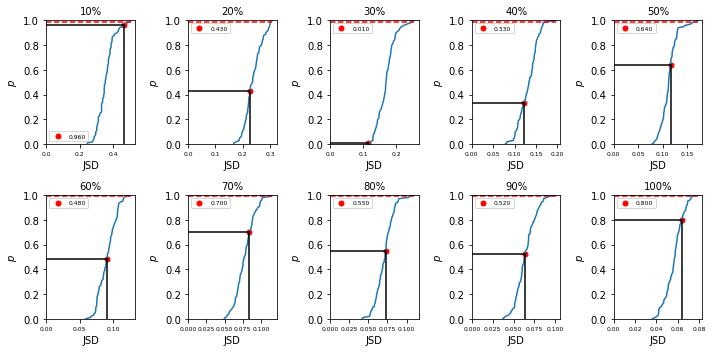

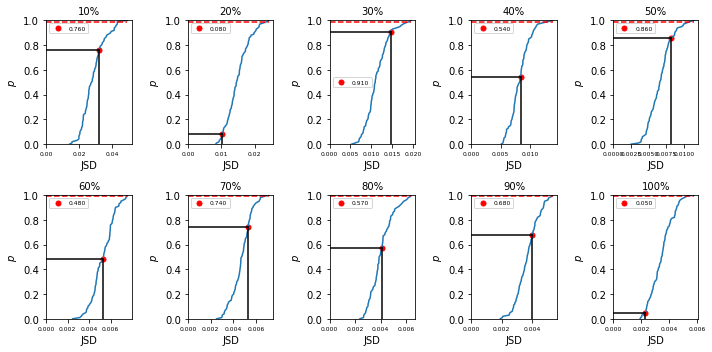

In [11]:
lam = 1.0
nsteps=1000000
ensemble = biceps.Ensemble(lam, energies)
ensemble.initialize_restraints(input_data, parameters)
sampler = biceps.PosteriorSampler(ensemble)
sampler.sample(nsteps=nsteps, print_freq=1000, verbose=False)
traj = sampler.traj.__dict__
init, frac = biceps.find_all_state_sampled_time(traj['state_trace'], len(energies))
C = biceps.Convergence(traj)
C.plot_traces(figname="test.pdf", xlim=(0, nsteps))
C.get_autocorrelation_curves(method="auto", maxtau=5000)
C.process()

<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [70]:
from IPython.core.display import HTML
def css_styling():
    styles = open("notebook_theme.css", "r").read()
    return HTML(styles)
css_styling()